# Testing Markov Chain Monte Carlo sampling algorithm

@Author: Ettore Biondi - ettore88@stanford.edu

## Problem definition

Now, we turn our attention onto sampling methods. We start with the very well-known sampling method called MCMC. We are going to extract samples of the following probability density function (PDF):
\begin{equation}
\phi(\mathbf{x}) = k_1 \exp^{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_1)^{T}\Sigma_1^{-1}(\mathbf{x}-\mathbf{\mu}_1)}+k_2 \exp^{-\frac{1}{2}(\mathbf{x}-\mathbf{\mu}_2)^{T}\Sigma_2^{-1}(\mathbf{x}-\mathbf{\mu}_2)},
\end{equation}
where two Gaussian multivariate distributions have been normalized summed together.

In [1]:
import numpy as np
import occamypy
#Plotting library
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
%matplotlib inline
params = {
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex':True
}
matplotlib.rcParams.update(params)

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


We first start by writing the problem class definition.

In [2]:
class multi_gauss_prblm(occamypy.Problem):
    """
	   Objective function containing two Gaussian functions at two different centers in the 2D plane
	"""

    def __init__(self, mu1, mu2, sigma1, sigma2):
        """
        Objective function containing two gaussian functions with mu1, mu2, sigma1, and sigma2 parameters
        :param mu1: 1D array - mean of the gaussian function 1
        :param mu2: 1D array - mean of the gaussian function 2
        :param sigma1: 2D array - variance matrix of gaussian function 1
        :param sigma2: 2D array - variance matrix of gaussian function 2
        """
        # Setting the bounds (if any)
        super(multi_gauss_prblm, self).__init__(None, None)
        # Gaussian parameters
        self.mu1 = mu1
        self.mu2 = mu2
        self.sigma1_inv = np.linalg.inv(sigma1)
        self.sigma2_inv = np.linalg.inv(sigma2)
        self.scale1 = 0.5 / (np.sqrt(np.linalg.det(sigma1) * (2.0 * np.pi) ** self.mu1.shape[0]))
        self.scale2 = 0.5 / (np.sqrt(np.linalg.det(sigma2) * (2.0 * np.pi) ** self.mu2.shape[0]))
        # Setting initial model
        self.model = occamypy.VectorIC(mu1.shape)
        self.dmodel = self.model.clone()
        self.dmodel.zero()
        # Gradient vector
        self.grad = self.dmodel.clone()
        # Residual vector
        self.res = occamypy.VectorIC(np.array((0.,)))
        # Dresidual vector
        self.dres = self.res.clone()
        # Setting default variables
        self.setDefaults()
        self.linear = False
        return

    def objf(self, model):
        """Objective function computation"""
        m = model.arr  # Getting ndArray of the model
        obj = self.res.arr[0]
        return obj

    def resf(self, model):
        """Residual function"""
        m1 = model.getNdArray() - self.mu1
        m2 = model.getNdArray() - self.mu2
        self.res.getNdArray()[0] = self.scale1 * np.exp(-0.5 * np.dot(m1, np.dot(self.sigma1_inv, m1))) \
                            + self.scale2 * np.exp(-0.5 * np.dot(m2, np.dot(self.sigma2_inv, m2)))
        return self.res

### Instantiation of the inverse problem and of the MCMC solver/sampler

In [3]:
mu1 = np.array([2.0, 1.5])
mu2 = np.array([-1.5, -3.0])
sigma1 = np.array([[1., 3. / 5.], [3. / 5., 2.]])
sigma2 = np.array([[2., -3. / 5.], [-3. / 5., 1.]])
pdf_gauss_prb = multi_gauss_prblm(mu1, mu2, sigma1, sigma2)

Let's now perform an extensive search, which will help us understand how the sampling method is performing on this PDF.

In [4]:
#Computing the objective function for plotting
x_samples = np.linspace(-5.,5.,1000)
y_samples = np.linspace(-6.,6.,1100)
pdf_gauss = occamypy.VectorIC(np.zeros((len(y_samples),len(x_samples))))
pdf_gaussNp = pdf_gauss.getNdArray()
sample_point = occamypy.VectorIC(np.array((0.0,0.0)))
sample_pointNp = sample_point.getNdArray()
for iy,y_value in enumerate(y_samples):
	for ix,x_value in enumerate(x_samples):
		sample_pointNp[0] = y_value
		sample_pointNp[1] = x_value
		pdf_gaussNp[iy,ix]=pdf_gauss_prb.get_obj(sample_point)

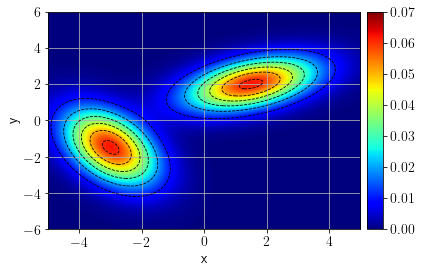

In [5]:
fig, ax = plt.subplots()
im = plt.imshow(np.flip(pdf_gaussNp, axis=0), cmap='jet',
                vmin=0.0, vmax=0.07, extent=[-5.,5.,-6.,6.0])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(x_samples, y_samples, pdf_gaussNp,
                 levels=[0.01,0.02,0.03,0.04,0.05,0.06],
                 colors="black",
                 linewidths=(0.8,),
                 linestyles='--')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')

The next step is to sample the PDF with a MCMC method.

In [6]:
MCMCsampler = occamypy.MCMC(stopper=occamypy.SamplingStopper(30000), prop_distr="Uni", max_step=5.0)
MCMCsampler.setDefaults(save_obj=True, save_model=True)
MCMCsampler.run(pdf_gauss_prb, verbose=False)

In [7]:
#Converting sampled points to arrays for plotting
burn_samples = 500
MCMC_samples = np.array([MCMCsampler.model[iter].getNdArray()
                         for iter in range(burn_samples, len(MCMCsampler.model))], copy=False)

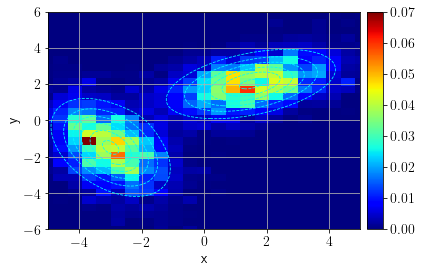

In [8]:
fig,ax=plt.subplots()
plt.hist2d(MCMC_samples[:,1],MCMC_samples[:,0], bins=[30,30], cmap='jet')
plt.xlabel("x")
plt.ylabel("y")
plt.grid()
cs = plt.contour(x_samples, y_samples, pdf_gaussNp,
                 levels=[0.01,0.02,0.03,0.04,0.05,0.06],
                 colors="cyan",
                 linewidths=(0.8,),
                 linestyles='--')
plt.xlim(-5, 5)
_=plt.ylim(-6, 6)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax)
ax.set_aspect('auto')